<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/deep_q_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Deep Q-Network implementation
包括三个组成部分：

- approximate q-learning
- experience replay
- target networks 

import os
os.system('apt-get install -y xvfb')

In [2]:
import os
os.system('apt-get install -y xvfb')

0

In [3]:
os.system('apt-get install graphviz')

0

In [4]:


os.system('pip install pydot pydot-ng')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
os.system('apt-get install -y python-opengl ffmpeg')
os.system('pip install pyglet==1.2.4')



if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


### 目标: 训练一个玩atari的agent
游戏数据信息：
- atari 游戏画面图像默认大小是210x160x3

为了节省时间，可以对图像进行resize操作，变成64x64的黑白图像。并且去除顶部和底部无用的图像区域。

In [0]:
from gym.core import ObservationWrapper
from gym.spaces import Box
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, (*self.img_size,1))
        print("self.observation_space={0}".format(self.observation_space.shape))

    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize imported above or any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type

        # crop image
        img=img[20:,:,:]
        # resize
        img = Image.fromarray(img.astype(np.uint8))
        img = img.resize((self.img_size[0], self.img_size[1]))
        # 灰度
        img = img.convert('L')

        #归一化：
        imgdata=np.array(img.getdata(),dtype='float32')
        min_val = np.min(imgdata)
        max_val = np.max(imgdata)
        imgdata = (imgdata-min_val)/max_val
        imgdata = imgdata.reshape((*self.img_size,1))
        #print("imgdata[0,:]".format(imgdata[0,:]))
        print("imgdata shape={0}".format(imgdata.shape))
        return imgdata

In [9]:
import gym
env = gym.make("BreakoutDeterministic-v0")
observation_shape = env.observation_space.shape
print("observation_shape={0}".format(observation_shape))
env = PreprocessAtari(env)
observation_shape = env.observation_space.shape
print("observation_shape={0}".format(observation_shape))
n_actions = env.action_space.n
obs = env.reset()


observation_shape=(210, 160, 3)
self.observation_space=(64, 64, 1)
observation_shape=(64, 64, 1)
imgdata shape=(64, 64, 1)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(64, 64, 1)
(64, 64, 1)
float32
Formal tests seem fine. Here's an example of what you'll get.


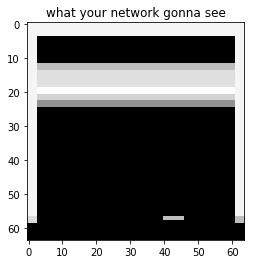

In [10]:
assert obs.ndim == 3, "observation must be [batch, time, channels] even if there's just one channel"
print(obs.shape)
print(observation_shape)
#assert obs.shape == observation_shape
print(obs.dtype)
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to (0,1) range"
print ("Formal tests seem fine. Here's an example of what you'll get.")

plt.title("what your network gonna see")
plt.imshow(obs.reshape([64,64]), interpolation='none', cmap='gray')


### Frame Buffer

单张图片训练时无法反应图片的速度和运动反向。所以这个实验采用连续四张图片进行训练

In [0]:
import numpy as np
from gym.spaces.box import Box
from gym.core import Wrapper


class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)

In [12]:

#包括图片预处理和frame buffer功能的env
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env


env = make_env()
s0 = env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
print(state_dim)

self.observation_space=(64, 64, 1)
imgdata shape=(64, 64, 1)
(64, 64, 4)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### 网络

In [0]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [14]:
from keras.layers import Conv2D, Dense, Flatten, InputLayer, MaxPooling2D
import keras

Using TensorFlow backend.


In [0]:
from keras.utils import plot_model
# Install dependencies


# Restart runtime to allow Jupyter to know the changes above
#import os
#os._exit(0)

from keras.models import Model
from keras.layers import Input, Dense
from keras.utils import plot_model
import keras.backend as K

class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        self.n_actions = n_actions
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            self.sess = tf.InteractiveSession()
            keras.backend.set_session(self.sess)
            #< Define your network body here. Please make sure you don't use any layers created elsewhere >
            # prepare a graph for agent step
            # 定义placeholder，接受(s, rewrad, action, next_state, is_done)
            self.states_ph = K.placeholder(dtype='float32', shape=(None,*state_shape))
            self.actions_ph = K.placeholder(dtype='int32', shape=(None))
            self.rewards_ph = K.placeholder(dtype='float32', shape=(None))
            self.next_states_ph = K.placeholder(dtype='float32', shape=(None,*state_shape))
            self.is_done_ph = K.placeholder(dtype='bool', shape=(None))

            self.img_size = 64
            self.gamma = 0.99
            self.network = keras.models.Sequential()
            self.network.add(InputLayer(state_shape))
            self.network.add(Conv2D(filters=16, kernel_size=3, strides=2, activation='relu'))
            self.network.add(Conv2D(filters=32, kernel_size=3, strides=2, activation='relu'))
            self.network.add(Conv2D(filters=64, kernel_size=3, strides=2, activation='relu'))
            self.network.add(MaxPooling2D(pool_size=(2,2)))
            self.network.add(Flatten())
            self.network.add(Dense(units=256, activation="relu"))
            self.network.add(Dense(units=n_actions))
            self.network.compile(loss='mean_squared_error',optimizer='sgd', metrics=['accuracy'])
            
            # 定义损失函数
            predicted_qvalues = self.network(self.states_ph)
            predicted_next_qvalues = self.network(self.next_states_ph)
            predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(self.actions_ph, n_actions), axis=1)
            next_state_values = K.max(predicted_next_qvalues, axis=-1)
            target_qvalues_for_actions = self.rewards_ph + (K.max(next_state_values) * self.gamma)
            target_qvalues_for_actions = tf.where(self.is_done_ph, self.rewards_ph, target_qvalues_for_actions)
            loss_val = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2
            self.loss = tf.reduce_mean(loss_val)

            # 优化目标
            self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)


        self.weights = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        qvalues = self.network(state_t)
        print("qvalues={0}".format(qvalues))

        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(
                qvalues)
        assert int(qvalues.shape[1]) == self.n_actions

        return qvalues

    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})

    def sample_actions(self, qvalues, epsilon=0):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)


state_dim=(64, 64, 4)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


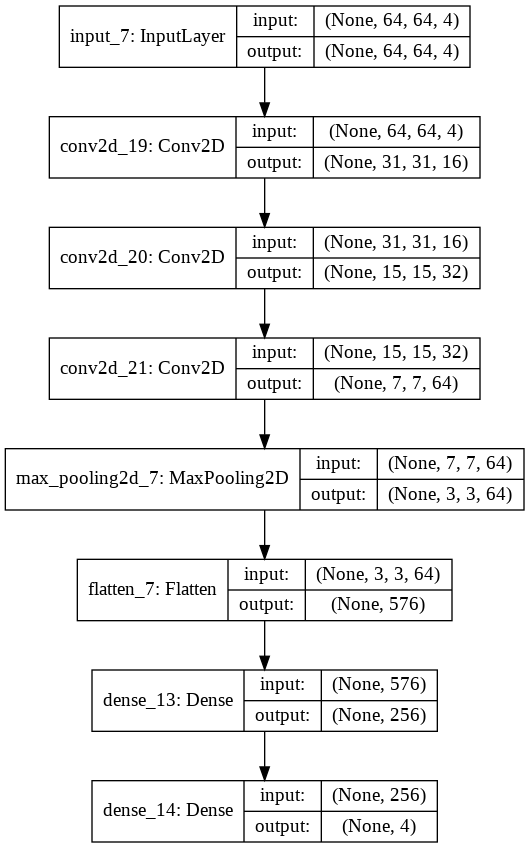

In [29]:
print("state_dim={0}".format(state_dim))
agent = DQNAgent(name="xww", state_shape=state_dim, n_actions=n_actions)
plot_model(agent.network, show_shapes=True, show_layer_names=True, to_file='model.png')


In [31]:
fb_env = FrameBuffer(env)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### 玩游戏，再优化

In [0]:


def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = fb_env.reset()
    
    for t in range(t_max):
        qvalues = agent.get_qvalues(s)
        a = agent.sample_actions(qvalues, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        
        if train:
            sess.run(train_step,{
                states_ph: [s], actions_ph: [a], rewards_ph: [r], 
                next_states_ph: [next_s], is_done_ph: [done]
            })

        total_reward += r
        s = next_s
        if done: break
            
    return total_reward